## OfflineTrajectory Optimization

In [ ]:
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
urdf_root_path = '/home/Go2py/Go2Py/assets'
urdf_path = '/home/Go2py/Go2Py/assets/urdf/go2_with_arm.urdf'
robot = pin.RobotWrapper.BuildFromURDF(
urdf_path, urdf_root_path, pin.JointModelFreeFlyer())

In [ ]:
import sys
import mim_solvers
pinRef        = pin.LOCAL_WORLD_ALIGNED
FRICTION_CSTR = True
MU = 0.8     # friction coefficient

In [ ]:
ee_frame_names = ['FL_FOOT', 'FR_FOOT', 'HL_FOOT', 'HR_FOOT', 'Link6']
rmodel = robot.model
rdata = robot.data
# # set contact frame_names and_indices
lfFootId = rmodel.getFrameId(ee_frame_names[0])
rfFootId = rmodel.getFrameId(ee_frame_names[1])
lhFootId = rmodel.getFrameId(ee_frame_names[2])
rhFootId = rmodel.getFrameId(ee_frame_names[3])
efId = rmodel.getFrameId(ee_frame_names[4])

In [ ]:
q0 = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452] + 8*[0.0]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

In [ ]:
q0 = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452] + 8*[0.0]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

pinocchio.forwardKinematics(rmodel, rdata, q0)
pinocchio.updateFramePlacements(rmodel, rdata)
rfFootPos0 = rdata.oMf[rfFootId].translation
rhFootPos0 = rdata.oMf[rhFootId].translation
lfFootPos0 = rdata.oMf[lfFootId].translation
lhFootPos0 = rdata.oMf[lhFootId].translation 
efPos0 = rdata.oMf[efId].translation

In [ ]:
comRef = (rfFootPos0 + rhFootPos0 + lfFootPos0 + lhFootPos0) / 4
comRef[2] = pinocchio.centerOfMass(rmodel, rdata, q0)[2].item() 
print(f'The desired CoM position is: {comRef}')

In [ ]:
supportFeetIds = [lfFootId, rfFootId, lhFootId, rhFootId]
supportFeePos = [lfFootPos0, rfFootPos0, lhFootPos0, rhFootPos0]

In [ ]:
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
nu = actuation.nu

In [ ]:
comDes = []

N_ocp = 250 #100
dt = 0.02
T = N_ocp * dt
radius = 0.065
for t in range(N_ocp+1):
    comDes_t = comRef.copy()
    w = (2 * np.pi) * 0.2 # / T
    comDes_t[0] += radius * np.sin(w * t * dt) 
    comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
    comDes += [comDes_t]

In [ ]:
import friction_utils
running_models = []
constraintModels = []

for t in range(N_ocp+1):
    contactModel = crocoddyl.ContactModelMultiple(state, nu)
    costModel = crocoddyl.CostModelSum(state, nu)

    # Add contact
    for frame_idx in supportFeetIds:
        support_contact = crocoddyl.ContactModel3D(state, frame_idx, np.array([0., 0., 0.]), pinRef, nu, np.array([0., 0.]))
        # print("contact name = ", rmodel.frames[frame_idx].name + "_contact")
        contactModel.addContact(rmodel.frames[frame_idx].name + "_contact", support_contact) 

    # Add state/control reg costs

    state_reg_weight, control_reg_weight = 1e-1, 1e-3

    freeFlyerQWeight = [0.]*3 + [500.]*3
    freeFlyerVWeight = [10.]*6
    legsQWeight = [0.01]*(rmodel.nv - 6)
    legsWWeights = [1.]*(rmodel.nv - 6)
    stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    


    stateResidual = crocoddyl.ResidualModelState(state, x0, nu)
    stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
    stateReg = crocoddyl.CostModelResidual(state, stateActivation, stateResidual)

    if t == N_ocp:
        costModel.addCost("stateReg", stateReg, state_reg_weight*dt)
    else:
        costModel.addCost("stateReg", stateReg, state_reg_weight)

    if t != N_ocp:
        ctrlResidual = crocoddyl.ResidualModelControl(state, nu)
        ctrlReg = crocoddyl.CostModelResidual(state, ctrlResidual)
        costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


    # Add COM task
    com_residual = crocoddyl.ResidualModelCoMPosition(state, comDes[t], nu)
    com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    com_track = crocoddyl.CostModelResidual(state, com_activation, com_residual) # What does it correspond to exactly?
    if t == N_ocp:
        costModel.addCost("comTrack", com_track, 1e5)
    else:
        costModel.addCost("comTrack", com_track, 1e5)

    # End Effecor Position Task
    ef_residual = crocoddyl.ResidualModelFrameTranslation(state, efId, efPos0, nu)
    ef_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    ef_track = crocoddyl.CostModelResidual(state, ef_activation, ef_residual)
    if t == N_ocp:
        costModel.addCost("efTrack", ef_track, 1e5)
    else:
        costModel.addCost("efTrack", ef_track, 1e5)
        

    constraintModelManager = crocoddyl.ConstraintModelManager(state, actuation.nu)
    if(FRICTION_CSTR):
        if(t != N_ocp):
            for frame_idx in supportFeetIds:
                name = rmodel.frames[frame_idx].name + "_contact"
                residualFriction = friction_utils.ResidualFrictionCone(state, name, MU, actuation.nu)
                constraintFriction = crocoddyl.ConstraintModelResidual(state, residualFriction, np.array([0.]), np.array([np.inf]))
                constraintModelManager.addConstraint(name + "friction", constraintFriction)

    dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contactModel, costModel, constraintModelManager, 0., True)
    model = crocoddyl.IntegratedActionModelEuler(dmodel, dt)

    running_models += [model]


In [ ]:
# Create shooting problem
ocp = crocoddyl.ShootingProblem(x0, running_models[:-1], running_models[-1])

solver = mim_solvers.SolverCSQP(ocp)
solver.max_qp_iters = 1000
max_iter = 500
solver.with_callbacks = True
solver.use_filter_line_search = False
solver.termination_tolerance = 1e-4
solver.eps_abs = 1e-6
solver.eps_rel = 1e-6

In [ ]:
xs = [x0]*(solver.problem.T + 1)
us = solver.problem.quasiStatic([x0]*solver.problem.T) 
solver.solve(xs, us, max_iter)   

In [ ]:
nq, nv, N = rmodel.nq, rmodel.nv, len(xs) 
jointPos_sol = []
jointVel_sol = []
jointAcc_sol = []
jointTorques_sol = []
centroidal_sol = []
xs, us = solver.xs, solver.us
x = []
for time_idx in range (N):
    q, v = xs[time_idx][:nq], xs[time_idx][nq:]
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.computeCentroidalMomentum(rmodel, rdata, q, v)
    centroidal_sol += [
        np.concatenate(
            [pin.centerOfMass(rmodel, rdata, q, v), np.array(rdata.hg.linear), np.array(rdata.hg.angular)]
            )
            ]
    jointPos_sol += [q]
    jointVel_sol += [v]
    x += [xs[time_idx]]
    if time_idx < N-1:
        jointAcc_sol +=  [solver.problem.runningDatas[time_idx].xnext[nq::]] 
        jointTorques_sol += [us[time_idx]]




sol = {'x':x, 'centroidal':centroidal_sol, 'jointPos':jointPos_sol, 
                    'jointVel':jointVel_sol, 'jointAcc':jointAcc_sol, 
                    'jointTorques':jointTorques_sol}       

for frame_idx in supportFeetIds:
    # print('extract foot id ', frame_idx, "_name = ", rmodel.frames[frame_idx].name)
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    datas = [solver.problem.runningDatas[i].differential.multibody.contacts.contacts[ct_frame_name] for i in range(N-1)]
    ee_forces = [datas[k].f.vector for k in range(N-1)] 
    sol[ct_frame_name] = [ee_forces[i] for i in range(N-1)]     
    

In [ ]:
import matplotlib.pyplot as plt
constrained_sol = sol
time_lin = np.linspace(0, T, solver.problem.T)
fig, axs = plt.subplots(4, 3, constrained_layout=True)
for i, frame_idx in enumerate(supportFeetIds):
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    forces = np.array(constrained_sol[ct_frame_name])
    axs[i, 0].plot(time_lin, forces[:, 0], label="Fx")
    axs[i, 1].plot(time_lin, forces[:, 1], label="Fy")
    axs[i, 2].plot(time_lin, forces[:, 2], label="Fz")
    # Add friction cone constraints 
    Fz_lb = (1./MU)*np.sqrt(forces[:, 0]**2 + forces[:, 1]**2)
    # Fz_ub = np.zeros(time_lin.shape)
    # axs[i, 2].plot(time_lin, Fz_ub, 'k-.', label='ub')
    axs[i, 2].plot(time_lin, Fz_lb, 'k-.', label='lb')
    axs[i, 0].grid()
    axs[i, 1].grid()
    axs[i, 2].grid()
    axs[i, 0].set_ylabel(ct_frame_name)
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()

axs[3, 0].set_xlabel(r"$F_x$")
axs[3, 1].set_xlabel(r"$F_y$")
axs[3, 2].set_xlabel(r"$F_z$")
fig.suptitle('Force', fontsize=16)


comDes = np.array(comDes)
centroidal_sol = np.array(constrained_sol['centroidal'])
plt.figure()
plt.plot(comDes[:, 0], comDes[:, 1], "--", label="reference")
plt.plot(centroidal_sol[:, 0], centroidal_sol[:, 1], label="solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("COM trajectory")
plt.show()

In [ ]:
mujoco_joint_names = \
['FL_hip_joint',
 'FL_thigh_joint',
 'FL_calf_joint',
 'FR_hip_joint',
 'FR_thigh_joint',
 'FR_calf_joint',
 'RL_hip_joint',
 'RL_thigh_joint',
 'RL_calf_joint',
 'RR_hip_joint',
 'RR_thigh_joint',
 'RR_calf_joint',
 'Joint1',
 'Joint2',
 'Joint3',
 'Joint4',
 'Joint5',
 'Joint6',
 'Joint7_1',
 'Joint7_2']

for joint_name in mujoco_joint_names:
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
    print(f'Joint {joint_name} has id {joint_id}')


In [ ]:
pinocchio_joint_names = \
['FL_HAA_joint',
 'FL_HFE_joint',
 'FL_KFE_joint',
    'FR_HAA_joint',
    'FR_HFE_joint',
    'FR_KFE_joint',
    'HL_HAA_joint',
    'HL_HFE_joint',
    'HL_KFE_joint',
    'HR_HAA_joint',
    'HR_HFE_joint',
    'HR_KFE_joint',
    'Joint1',
    'Joint2',
    'Joint3',
    'Joint4',
    'Joint5',
    'Joint6',
    'Joint7_1',
    'Joint7_2']


for joint_name in pinocchio_joint_names:
    joint_id = rmodel.getJointId(joint_name)
    print(f'Joint {joint_name} has id {joint_id}')


In [ ]:
pin_idx_to_mujoco_idx = []
for i in range(len(pinocchio_joint_names)):
    joint_name = pinocchio_joint_names[i]
    pin_joint_id = rmodel.getJointId(joint_name)
    mujoco_joint_name = mujoco_joint_names[i]
    mujoco_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, mujoco_joint_name)
    pin_idx_to_mujoco_idx.append(mujoco_joint_id)

pin_idx_to_mujoco_idx = np.array(pin_idx_to_mujoco_idx) - min(pin_idx_to_mujoco_idx)

In [ ]:
import mujoco
model = mujoco.MjModel.from_xml_path('/home/Go2py/Go2Py/assets/mujoco/go2_with_arm.xml')
data = mujoco.MjData(model)
viewer = mujoco.viewer.launch_passive(model, data)

In [ ]:
import time
for k in range(1000):
    i = k % len(xs)
    q0 = xs[i][:27]
    qx = q0[3]
    qy = q0[4]
    qz = q0[5]
    qw = q0[6]
    q0[3:7] = [qw, qx, qy, qz]
    q0[7:] = q0[7:][pin_idx_to_mujoco_idx]
    data.qpos[:] = q0

    mujoco.mj_step(model, data)
    viewer.sync()
    time.sleep(1/60)

## Online MPC

In [1]:
from Go2Py.sim.mujoco import Go2Sim
import numpy as np
robot=Go2Sim(with_arm=True)

In [2]:
map = np.zeros((1200, 1200))
# map[:,649:679] = 400
map[:,653:679] = 400
robot.updateHeightMap(map)

In [3]:
import os
import sys
import mim_solvers
import friction_utils
import mujoco
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
import mujoco.viewer

class Go2MPC:
    def __init__(self, assets_path, HORIZON=250, friction_mu = 0.2, dt = 0.02):
        self.assets_path = assets_path
        self.HORIZON = HORIZON
        self.max_iterations = 500
        self.dt = dt
        self.urdf_path = os.path.join(assets_path, 'urdf/go2_with_arm.urdf')
        self.xml_path = os.path.join(assets_path, 'mujoco/go2_with_arm.xml')
        self.pin_robot = pin.RobotWrapper.BuildFromURDF(self.urdf_path, self.assets_path, pin.JointModelFreeFlyer())
        self.pinRef = pin.LOCAL_WORLD_ALIGNED
        self.friction_mu = friction_mu 
        self.rmodel = self.pin_robot.model
        self.rdata = self.pin_robot.data

        self.mpc_to_unitree_name_map = \
        {'FL_HAA_joint':'FL_hip_joint',
         'FL_HFE_joint':'FL_thigh_joint',
         'FL_KFE_joint':'FL_calf_joint',
         'FR_HAA_joint':'FR_hip_joint',
         'FR_HFE_joint':'FR_thigh_joint',
         'FR_KFE_joint':'FR_calf_joint',
         'HL_HAA_joint':'RL_hip_joint',
         'HL_HFE_joint':'RL_thigh_joint',
         'HL_KFE_joint':'RL_calf_joint',
         'HR_HAA_joint':'RR_hip_joint',
         'HR_HFE_joint': 'RR_thigh_joint',
         'HR_KFE_joint': 'RR_calf_joint',
         'Joint1':'Joint1',
         'Joint2':'Joint2',
         'Joint3':'Joint3',
         'Joint4':'Joint4',
         'Joint5':'Joint5',
         'Joint6':'Joint6'
         }
        self.unitree_to_mpc_name_map = {val:key for key, val in self.mpc_to_unitree_name_map.items()}
        self.unitree_joint_order = ['FR', 'FL', 'RR', 'RL']

        mpc_to_unitree_idx_map = {}
        unitree_id = 0
        for foot_name in self.unitree_joint_order:
            for actuator in ['_hip_joint', '_thigh_joint', '_calf_joint']:
                unitree_actuator_name = foot_name+actuator
                mpc_joint_name = self.unitree_to_mpc_name_map[unitree_actuator_name]
                mpc_joint_id = self.rmodel.getJointId(mpc_joint_name)
                mpc_to_unitree_idx_map[mpc_joint_id-2]=unitree_id
                unitree_id+=1

        for unitree_actuator_name in ['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6']:
                mpc_joint_name = self.unitree_to_mpc_name_map[unitree_actuator_name]
                mpc_joint_id = self.rmodel.getJointId(mpc_joint_name)
                mpc_to_unitree_idx_map[mpc_joint_id-2]=unitree_id
                unitree_id+=1

        self.mpc_to_unitree_idx = np.zeros(18).astype(np.int32)    # mpc_state[mpc_to_unitree_idx] -> state/command in unitree order 
        self.unitree_to_mpc_idx = np.zeros(18).astype(np.int32)        # unitree_state[unitree_to_mpc] -> state/command in mpc order
        for mpc_idx, unitree_idx in mpc_to_unitree_idx_map.items():
            self.mpc_to_unitree_idx[mpc_idx] = unitree_idx
            self.unitree_to_mpc_idx[unitree_idx] = mpc_idx

        # set contact frame_names and_indices
        ee_frame_names = ['FL_FOOT', 'FR_FOOT', 'HL_FOOT', 'HR_FOOT', 'Link6']
        self.lfFootId = self.rmodel.getFrameId(ee_frame_names[0])
        self.rfFootId = self.rmodel.getFrameId(ee_frame_names[1])
        self.lhFootId = self.rmodel.getFrameId(ee_frame_names[2])
        self.rhFootId = self.rmodel.getFrameId(ee_frame_names[3])
        self.armEEId = self.rmodel.getFrameId(ee_frame_names[4])
        self.running_models = []
        self.constraintModels = []
        
        self.ccdyl_state = crocoddyl.StateMultibody(self.rmodel)
        self.ccdyl_actuation = crocoddyl.ActuationModelFloatingBase(self.ccdyl_state)
        self.nu = self.ccdyl_actuation.nu

    def initialize(self, q0=np.array([0.0, 0.0, 0.33, 0.0, 0.0, 0.0, 1.0] 
                    +4*[0.0, 0.77832842, -1.56065452] + [0.0, 0.3, -0.3, 0.0, 0.0, 0.0]
                        )):
        q0[11+2]=0.0
        self.q0 = q0.copy()
        self.x0 =  np.concatenate([q0, np.zeros(self.rmodel.nv)])
        pinocchio.forwardKinematics(self.rmodel, self.rdata, q0)
        pinocchio.updateFramePlacements(self.rmodel, self.rdata)
        self.rfFootPos0 = self.rdata.oMf[self.rfFootId].translation
        self.rhFootPos0 = self.rdata.oMf[self.rhFootId].translation
        self.lfFootPos0 = self.rdata.oMf[self.lfFootId].translation
        self.lhFootPos0 = self.rdata.oMf[self.lhFootId].translation 
        self.armEEPos0 = self.rdata.oMf[self.armEEId].translation
        self.armEEOri0 = self.rdata.oMf[self.armEEId].rotation
        self.supportFeetIds = [self.lfFootId, self.rfFootId, self.lhFootId, self.rhFootId]
        # self.supportFeePos = [self.lfFootPos0, self.rfFootPos0, self.lhFootPos0, self.rhFootPos0]
        self.xs = [self.x0]*(self.HORIZON + 1)
        self.createProblem()
        self.createSolver()
        self.us = self.solver.problem.quasiStatic([self.x0]*self.HORIZON) 

    def createProblem(self):
        #First compute the desired state of the robot
        comRef = (self.rfFootPos0 + self.rhFootPos0 + self.lfFootPos0 + self.lhFootPos0) / 4
        comRef[2] = pinocchio.centerOfMass(self.rmodel, self.rdata, self.q0)[2].item() 
        eeDes = self.armEEPos0
        comDes = []
        dt = self.dt
        # radius = 0.065
        radius = 0.0
        for t in range(self.HORIZON+1):
            comDes_t = comRef.copy()
            w = (2 * np.pi) * 0.2 # / T
            comDes_t[0] += radius * np.sin(w * t * dt) 
            comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
            comDes += [comDes_t]
        body_com_ref = comDes
        arm_eff_ref = [eeDes]*(self.HORIZON+1)
        # Now define the model
        for t in range(self.HORIZON+1):
            self.contactModel = crocoddyl.ContactModelMultiple(self.ccdyl_state, self.nu)
            costModel = crocoddyl.CostModelSum(self.ccdyl_state, self.nu)

            # Add contacts
            for frame_idx in self.supportFeetIds:
                support_contact = crocoddyl.ContactModel3D(self.ccdyl_state, frame_idx, np.array([0., 0., 0.]), self.pinRef, self.nu, np.array([0., 0.]))
                self.contactModel.addContact(self.rmodel.frames[frame_idx].name + "_contact", support_contact) 

            # Contact for the EE
            support_contact = crocoddyl.ContactModel3D(self.ccdyl_state, self.armEEId, np.array([0., 0., 0.0]), pin.LOCAL_WORLD_ALIGNED, self.nu, np.array([0., 0.]))
            self.contactModel.addContact(self.rmodel.frames[self.armEEId].name + "_contact", support_contact) 
            # Add state/control regularization costs
            state_reg_weight, control_reg_weight = 1e-1, 1e-3

            freeFlyerQWeight = [0.]*3 + [500.]*3
            freeFlyerVWeight = [10.]*6
            legsQWeight = [0.01]*(self.rmodel.nv - 6)
            legsWWeights = [1.]*(self.rmodel.nv - 6)
            stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    
            stateResidual = crocoddyl.ResidualModelState(self.ccdyl_state, self.x0, self.nu)

            stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
            stateReg = crocoddyl.CostModelResidual(self.ccdyl_state, stateActivation, stateResidual)

            if t == self.HORIZON:
                costModel.addCost("stateReg", stateReg, state_reg_weight*self.dt)
            else:
                costModel.addCost("stateReg", stateReg, state_reg_weight)

            if t != self.HORIZON:
                ctrlResidual = crocoddyl.ResidualModelControl(self.ccdyl_state, self.nu)
                ctrlReg = crocoddyl.CostModelResidual(self.ccdyl_state, ctrlResidual)
                costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


            # Body COM Tracking Cost
            com_residual = crocoddyl.ResidualModelCoMPosition(self.ccdyl_state, body_com_ref[t], self.nu)
            com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            com_track = crocoddyl.CostModelResidual(self.ccdyl_state, com_activation, com_residual) # What does it correspond to exactly?
            # if t == self.HORIZON:
            #     # costModel.addCost("comTrack", com_track, 1e5)
            #     costModel.addCost("comTrack", com_track, 1e5)
            # else:
            #     costModel.addCost("comTrack", com_track, 1e1)

            # End Effecor Position Tracking Cost
            # ef_residual = crocoddyl.ResidualModelFrameTranslation(self.ccdyl_state, self.armEEId, arm_eff_ref[t], self.nu) # Check this cost term            
            # ef_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            # ef_track = crocoddyl.CostModelResidual(self.ccdyl_state, ef_activation, ef_residual)

            ef_rotation_residual = crocoddyl.ResidualModelFrameRotation(self.ccdyl_state, self.armEEId, self.armEEOri0, self.nu)
            ef_rot_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            ef_rot_track = crocoddyl.CostModelResidual(self.ccdyl_state, ef_rot_activation, ef_rotation_residual)
            if t == self.HORIZON:
                # costModel.addCost("efTrack", ef_track, 1e5)
                costModel.addCost("efRotTrack", ef_rot_track, 1e5)
                
            else:
                # costModel.addCost("efTrack", ef_track, 1e1)
                costModel.addCost("efRotTrack", ef_rot_track, 1e1)
            # Force tracking term
            self.ef_des_force = pin.Force()
            self.ef_des_force.linear[2] = 0
            contact_force_residual = crocoddyl.ResidualModelContactForce(self.ccdyl_state, self.armEEId, self.ef_des_force, 3, self.nu)
            contact_force_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            contact_force_track = crocoddyl.CostModelResidual(self.ccdyl_state, contact_force_activation, contact_force_residual)
            if t == self.HORIZON:
                costModel.addCost("contact_force_track", contact_force_track, 1e5)
            else:
                costModel.addCost("contact_force_track", contact_force_track, 1e1)
                
    
            # Friction Cone Constraints
            constraintModelManager = crocoddyl.ConstraintModelManager(self.ccdyl_state, self.ccdyl_actuation.nu)
            if(t != self.HORIZON):
                for frame_idx in self.supportFeetIds:
                    name = self.rmodel.frames[frame_idx].name + "_contact"
                    residualFriction = friction_utils.ResidualFrictionCone(self.ccdyl_state, name, self.friction_mu, self.ccdyl_actuation.nu)
                    constraintFriction = crocoddyl.ConstraintModelResidual(self.ccdyl_state, residualFriction, np.array([0.]), np.array([np.inf]))
                    constraintModelManager.addConstraint(name + "friction", constraintFriction)
            #friction model for the arm
            # name = self.rmodel.frames[self.armEEId].name + "_contact"
            # residualFriction = friction_utils.ResidualFrictionCone(self.ccdyl_state, name, self.friction_mu, self.ccdyl_actuation.nu)
            # constraintFriction = crocoddyl.ConstraintModelResidual(self.ccdyl_state, residualFriction, np.array([0.]), np.array([np.inf]))
            # constraintModelManager.addConstraint(name + "friction", constraintFriction)
            
            dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(self.ccdyl_state, self.ccdyl_actuation, self.contactModel, costModel, constraintModelManager, 0., True)
            model = crocoddyl.IntegratedActionModelEuler(dmodel, self.dt)
            self.running_models += [model]
        self.ocp = crocoddyl.ShootingProblem(self.x0, self.running_models[:-1], self.running_models[-1])
        
    def createSolver(self):
        solver = mim_solvers.SolverCSQP(self.ocp)
        solver.max_qp_iters = 25
        solver.with_callbacks = True
        solver.use_filter_line_search = False
        solver.termination_tolerance = 1e-2
        solver.eps_abs = 1e-2
        solver.eps_rel = 0.
        self.solver = solver

    def getSolution(self, k=None):
        if k is None: 
            x_idx = 1
            u_idx = 0
        else:
            x_idx = k
            u_idx = k
        t = self.xs[x_idx][:3]
        quat = self.xs[x_idx][3:7]
        qx = quat[0]
        qy = quat[1]
        qz = quat[2]
        qw = quat[3]
        q = self.xs[x_idx][7:25]
        eta = self.xs[x_idx][25:25+6]
        dq = self.xs[x_idx][25+6:]
        constraint_norm = self.solver.constraint_norm
        return dict(
            position=t,
            orientation=np.array([qw, qx, qy, qz]), #Mujoco and uniree quaternion order
            velocity = eta[:3],
            omega = eta[3:],
            q = q[self.mpc_to_unitree_idx],
            dq = dq[self.mpc_to_unitree_idx], 
            tau = self.us[u_idx][[self.mpc_to_unitree_idx]],
            constraint_norm = constraint_norm
        )
    
    def updateAndSolve(self, t, quat, q, v, omega, dq):
        q_ = np.zeros(self.rmodel.nq)
        dq_ = np.zeros(self.rmodel.nv)
        qw = quat[0]
        qx = quat[1]
        qy = quat[2]
        qz = quat[3]
        q_[:3] = t
        q_[3:7] = np.array([qx, qy, qz, qw])
        q_[7:] = q[self.unitree_to_mpc_idx]
        dq_[:3] = v
        dq_[3:6] = omega
        dq_[6:] = dq[self.unitree_to_mpc_idx]
        pin.framesForwardKinematics(self.rmodel, self.rdata, q_)
        x = np.hstack([q_, dq_])
        self.solver.problem.x0 = x
        self.xs = list(self.solver.xs[1:]) + [self.solver.xs[-1]]
        self.xs[0] = x
        self.us = list(self.us[1:]) + [self.us[-1]] 
        self.solver.solve(self.xs, self.us, self.max_iterations)
        self.xs, self.us = self.solver.xs, self.solver.us
        return self.getSolution()
    
    def solve(self):
        self.solver.solve(self.xs, self.us, self.max_iterations)
        self.xs, self.us = self.solver.xs, self.solver.us
        return self.getSolution()

In [4]:
assets_path = '/home/Go2py/Go2Py/assets'
mpc = Go2MPC(assets_path, HORIZON=20, friction_mu=0.1)
# mpc = Go2MPC(assets_path, HORIZON=20, friction_mu=0.1)

In [5]:

mpc.initialize()
mpc.solve()
m = list(mpc.solver.problem.runningModels) + [mpc.solver.problem.terminalModel]
for action_model in m:
    action_model.differential.contacts.changeContactStatus('Link6_contact', False)
mpc.solve()

iter     merit        cost       ||gaps||   ||Constraint||  ||(dx,du)||     step   KKT criteria  QP iters 
   1  1.4187e+03   1.4187e+03   1.8250e-11    0.0000e+00    1.64565e+01    0.2500      ----        1
   2  1.0276e+03   7.9827e+02   2.7192e-01    2.2657e+01    9.00467e+00    1.0000   3.4495e+01     3
   3  2.3304e+02   3.9179e-02   5.0619e+00    1.8238e+01    4.48684e-01    1.0000   1.8238e+01     3
   4  2.4402e-01   2.6907e-02   1.5285e-03    2.0183e-02    1.99059e-01    1.0000   2.0183e-02     3
 END  3.6830e-02   2.6903e-02   5.3920e-05    9.3885e-04       ----         ----    3.3589e-03    -----
iter     merit        cost       ||gaps||   ||Constraint||  ||(dx,du)||     step   KKT criteria  QP iters 
 END  7.0234e-02   2.6902e-02   3.3943e-03    9.3887e-04       ----         ----    7.8730e-03    -----


{'position': array([7.64245650e-05, 1.19914809e-06, 3.30076878e-01]),
 'orientation': array([ 1.00000000e+00, -6.81801566e-09, -2.91826441e-07, -3.19038422e-07]),
 'velocity': array([3.82122935e-03, 5.99585975e-05, 3.84391623e-03]),
 'omega': array([-6.81801566e-07, -2.91826441e-05, -3.19038422e-05]),
 'q': array([-3.53840354e-06,  7.78324126e-01, -1.56013948e+00, -3.53840354e-06,
         7.78326989e-01, -1.56014401e+00, -4.35362308e-06,  7.78324619e-01,
        -1.56014046e+00, -4.35362308e-06,  7.78328001e-01, -1.56014604e+00,
        -2.71600731e-06,  2.99623852e-01, -2.99131121e-01,  6.58396878e-07,
        -3.77311125e-04,  4.55605926e-07]),
 'dq': array([-1.76920177e-04, -2.14688789e-04,  2.57521924e-02, -1.76920177e-04,
        -7.15256885e-05,  2.55252730e-02, -2.17681154e-04, -1.90062091e-04,
         2.57028413e-02, -2.17681154e-04, -2.09729748e-05,  2.54239671e-02,
        -1.35800366e-04, -1.88073907e-02,  4.34439336e-02,  3.29198439e-05,
        -1.88655563e-02,  2.278029

In [6]:
import time
for i in range(mpc.HORIZON):
# for i in range(1):
    q = np.zeros(27)
    # state = mpc.getSolution(i)
    state = mpc.getSolution(0)
    robot.pos0 = state['position']
    robot.rot0 = state['orientation']
    robot.q0 = state['q']
    robot.reset()
    time.sleep(0.01)

In [7]:
for action_model in m:
    # action_model.differential.costs.costs['contact_force_track'].cost.residual.reference.linear[2] = 0
    # action_model.differential.costs.costs['contact_force_track'].weight =0
    # action_model.differential.costs.costs['efTrack'].active = True
    action_model.differential.contacts.changeContactStatus('Link6_contact', True)
    action_model.differential.costs.costs['contact_force_track'].cost.residual.reference.linear[:] = np.array([-5, 0, 0])

In [8]:
import mujoco as mj
def getForceSensor(model, data, site_id):
    site_id = mj.mj_name2id(model,mj.mjtObj.mjOBJ_SITE, 'EF_force_site')
    world_R_sensor = data.xmat[site_id].reshape(3,3).T
    force_in_body = data.sensordata[-3:].reshape(3,1)
    force_in_world = world_R_sensor@force_in_body
    return force_in_world

In [19]:
mpc.max_iterations=250
measured_forces = []
forces = np.linspace(0, 30, 500)

for i in range(500):
    for action_model in m:
        action_model.differential.costs.costs['contact_force_track'].cost.residual.reference.linear[:] = np.array([-forces[i], 0, 0])

    state = robot.getJointStates()
    q = state['q']
    dq = state['dq']
    t, quat = robot.getPose()
    v = robot.data.qvel[:3]
    omega = robot.data.qvel[3:6]
    q = np.hstack([q, np.zeros(2)])
    dq = np.hstack([dq, np.zeros(2)])
    solution = mpc.updateAndSolve(t, quat, q, v, omega, dq)
    mpc.max_iterations=50

    # solution=mpc.getSolution()
    q = solution['q']
    dq = solution['dq']
    tau = solution['tau'].squeeze()
    kp = np.ones(18)*0.
    kv = np.ones(18)*0.
    
    for j in range(1):
        robot.setCommands(q, dq, kp, kv, tau)
        robot.step()
        time.sleep(0.0005)

    force_sensor_site = 'EF_force_site'
    measured_forces.append(getForceSensor(robot.model, robot.data, force_sensor_site).squeeze().copy())

iter     merit        cost       ||gaps||   ||Constraint||  ||(dx,du)||     step   KKT criteria  QP iters 
   1  2.2378e+02   9.9770e+01   1.1491e+01    9.1010e-01    4.80228e+00    0.1250      ----        3
   2  2.1380e+02   7.6389e+01   9.9404e+00    3.8008e+00    4.14732e+00    0.5000   1.1750e+01     3
   3  1.5072e+02   1.9077e+01   3.6168e+00    9.5471e+00    2.17564e+00    1.0000   9.5471e+00     3
   4  6.0622e+01   6.8999e-02   8.2992e-01    5.2253e+00    1.02132e+00    0.2500   5.2253e+00     3
   5  5.0684e+01   6.8959e-02   6.2229e-01    4.4393e+00    7.74598e-02    1.0000   4.4393e+00     3
 END  7.8577e-02   6.9011e-02   9.5660e-04    0.0000e+00       ----         ----    4.2526e-03    -----
iter     merit        cost       ||gaps||   ||Constraint||  ||(dx,du)||     step   KKT criteria  QP iters 
   1  2.7318e+01   7.4555e-02   2.7244e+00    0.0000e+00    5.60400e-01    0.2500      ----        1
   2  2.4399e+01   7.1720e-02   2.0459e+00    3.8688e-01    3.91568e-01    1

KeyboardInterrupt: 

In [20]:
measured_forces

[array([ 2.36041365, -0.01271313,  0.21047075]),
 array([ 2.012907  , -0.01195061,  0.15061032]),
 array([-7.19264913e-02, -2.43680904e-04,  3.20132220e-01]),
 array([-7.35830100e-02, -2.28343417e-04,  3.29105130e-01]),
 array([-7.48201848e-02, -2.51832990e-04,  3.36572438e-01]),
 array([-7.58311067e-02, -2.52655457e-04,  3.42880538e-01]),
 array([-7.67749819e-02, -2.45489330e-04,  3.48139460e-01]),
 array([-7.74147732e-02, -2.45611115e-04,  3.52593208e-01]),
 array([-7.51799907e-02, -2.49595235e-04,  3.52291887e-01]),
 array([-7.27421838e-02, -2.58548279e-04,  3.51466826e-01]),
 array([-7.03909194e-02, -2.51109477e-04,  3.50251399e-01]),
 array([-6.81643896e-02, -2.68337988e-04,  3.48610655e-01]),
 array([-6.58271340e-02, -2.73744534e-04,  3.47002290e-01]),
 array([-6.35328870e-02, -2.80816844e-04,  3.45191680e-01]),
 array([-6.12988905e-02, -2.75578158e-04,  3.43166249e-01]),
 array([-5.90895554e-02, -2.90596650e-04,  3.41010062e-01]),
 array([-5.68938808e-02, -2.88333367e-04,  3.387

In [21]:
getForceSensor(robot.model, robot.data, force_sensor_site)

array([[ 8.06672995],
       [-0.02972225],
       [ 0.63571668]])

In [22]:
measured_forces = np.array(measured_forces)

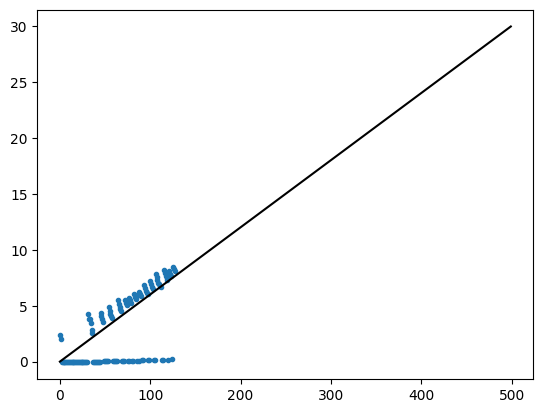

In [24]:
import matplotlib.pyplot as plt
plt.plot(measured_forces[:300,0],'.')
plt.plot(forces,'k')

In [29]:
for i in range(20):
    m[i].differential.contacts.changeContactStatus('Link6_contact', True)

In [70]:
for i in range(len(mpc.solver.problem.runningDatas)):
    print(mpc.solver.problem.runningDatas[i].differential.costs.costs['contact_force_track'].cost)

3.204797053666826e-05
2.9483716376834795e-05
2.7619477044929236e-05
2.5276355798602247e-05
2.326922954256662e-05
2.1509695934123958e-05
1.974757393335907e-05
1.791699699688713e-05
1.6054902037289995e-05
1.4193750943263636e-05
1.2351430002573735e-05
1.0528752339604057e-05
8.747743455994619e-06
7.157192535647804e-06
6.037534948060255e-06
5.56430443548056e-06
6.128822190129092e-06
8.373882310508166e-06
1.122733115529139e-05
3.663458594648195e-05


In [ ]:
for i in range(len(m)):
    print(m[i].differential.costs.costs['contact_force_track'].weight)

In [102]:
getForceInWorld(robot, force_in_body, force_sensor_site)

array([[-35.4984317 ],
       [  6.85876494],
       [ 36.03953757]])

In [ ]:
site_Fs = robot.data.sensordata[10:].reshape(-1,3)
site_Fs


In [ ]:
getForceInWorld(robot, force_in_body, force_sensor_site).squeeze()

In [ ]:
f = np.array(efs)
f.shape

In [ ]:
f = np.array(efs)
import matplotlib.pyplot as plt
plt.plot(f[:,-1,...])

In [ ]:
T = np.array([[1, 0, 0., 1], [0, -1, 0, -1], [0, 0, -1, 2], [0, 0, 0, 1]])
np.linalg.inv(T)@np.array([0, 0, 1, 1]).reshape(4,1)

In [ ]:
np.linalg.norm(np.array([-1.7, 1.7, -0.7])-np.array([0.4, 0.2, -0.15]))

In [106]:
robot.data.sensordata[-3:]

array([-2.78942222,  0.09545357, 14.59104325])

In [31]:
import mujoco as mj

In [125]:
import mujoco as mj



def getForceInWorld(robot, force_in_body, force_sensor_site):
    force_site_id = mj.mj_name2id(robot.model, mj.mjtObj.mjOBJ_SITE, force_sensor_site)
    q = robot.data.xquat[force_site_id]
    R = np.zeros(9)
    mj.mju_quat2Mat(R, q)
    R = R.reshape(3,3)
    T = np.eye(4)
    T[:3,:3] = R
    force_in_world = R@force_in_body.reshape(3,1)
    return force_in_world[:3]


force_site_to_sensor_idx = {'FL_force_site': 0, 'FR_force_site': 1, 'RL_force_site': 2, 'RR_force_site': 3, 'EF_force_site': 4}
force_sensor_site = 'EF_force_site'

site_Fs = robot.data.sensordata[10:].reshape(-1,3).T
force_in_body = site_Fs[:,force_site_to_sensor_idx[force_sensor_site]].copy()
getForceInWorld(robot, force_in_body, force_sensor_site)

array([[-14.0236976 ],
       [  0.12457404],
       [ 11.73103634]])

In [131]:
force_site_id = mj.mj_name2id(robot.model, mj.mjtObj.mjOBJ_SITE, force_sensor_site)
q = robot.data.xquat[force_site_id]
t = robot.data.xpos[force_site_id]
R = np.zeros(9)
mj.mju_quat2Mat(R, q)
R = R.reshape(3,3)
T = np.eye(4)
T[:3,:3] = R
T[:3,3] = t
R.T@robot.data.sensordata[-3:].reshape(3,1)
R

array([[ 7.41051792e-01, -2.11092834e-05, -6.71447869e-01],
       [ 1.02491083e-03,  9.99998870e-01,  1.09971716e-03],
       [ 6.71447088e-01, -1.50312157e-03,  7.41050976e-01]])

In [132]:
from scipy.spatial.transform import Rotation as R   
R.from_quat([q[1], q[2], q[3], q[0]]).as_matrix()

array([[ 7.41051792e-01, -2.11092834e-05, -6.71447869e-01],
       [ 1.02491083e-03,  9.99998870e-01,  1.09971716e-03],
       [ 6.71447088e-01, -1.50312157e-03,  7.41050976e-01]])

In [133]:
q

array([ 9.33019512e-01, -6.97423445e-04, -3.59824993e-01,  2.80278198e-04])

In [124]:
robot.data.sensordata[-3:]

array([-2.51538838,  0.10723676, 18.1096148 ])